In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb

import sys
sys.path.append('../')

from src.functions import Functions
from src.modeling import Modeling

import warnings
warnings.filterwarnings('ignore')

In [2]:
features = pd.read_csv('../data/raw_data/features.csv')
sales_train = pd.read_csv('../data/raw_data/train.csv')
stores = pd.read_csv('../data/raw_data/stores.csv')
sales_test = pd.read_csv('../data/raw_data/test.csv')

#### 欠損値の穴埋め

In [3]:
features = Functions.rollingInterpolation(features)

#### train, testのマージ

In [4]:
df_all_train = sales_train.merge(features, how="left", on=["Store","Date","IsHoliday"]).merge(stores, how="left", on=["Store"])
df_all_test = sales_test.merge(features, how="left", on=["Store","Date","IsHoliday"]).merge(stores, how="left", on=["Store"])

df_all_train['train_or_test'] = 'train'
df_all_test['train_or_test'] = 'test'
merged_df = pd.concat([df_all_train, df_all_test], sort=False)

merged_df = merged_df.sort_values(by=['Store','Dept','Date'], axis=0).reset_index().drop(columns='index')

#### カテゴリカルエンコーディング

In [5]:
merged_df = pd.get_dummies(merged_df, columns=["Type"])

LE = LabelEncoder()
merged_df['IsHoliday'] = LE.fit_transform(merged_df['IsHoliday'])

#### 休日の追加

In [6]:
merged_df = Functions.appendHolidayFlag(merged_df)

#### 時間に関する特徴量の追加

In [7]:
merged_df = Functions.addDateFeature(merged_df)

#### ラグ特徴量の追加

In [8]:
merged_df = Functions.createLagFeatures(merged_df)

#### 時間ごとの統計量に関する特徴量の追加

In [9]:
merged_df =  Functions.createDateStatsFeatures(merged_df, 'Monthly_Sales_', ['Store','Dept', 'Month'])
merged_df =  Functions.createDateStatsFeatures(merged_df, 'Daily_Sales_', ['Store','Dept', 'Day'])
merged_df =  Functions.createDateStatsFeatures(merged_df, 'WeekofMonth_Sales_', ['Store','Dept', 'WeekofMonth'])
merged_df =  Functions.createDateStatsFeatures(merged_df, 'WeekofYear_Sales_', ['Store','Dept', 'WeekofYear'])

#### 集計に関する特徴量の大量追加

In [10]:
merged_df =  Functions.createDateStatsFeatures(merged_df, 'Size_Sales_', ['Store','Dept', 'Size'])
merged_df =  Functions.createDateStatsFeatures(merged_df, 'IsHoliday_Sales_', ['Store','Dept', 'IsHoliday'])

merged_df =  Functions.createDateStatsFeatures(merged_df, 'Size_Month_Sales_', ['Store','Dept', 'Size', 'Month'])
merged_df =  Functions.createDateStatsFeatures(merged_df, 'IsHoliday_Month_Sales_', ['Store','Dept', 'IsHoliday','Month'])
merged_df =  Functions.createDateStatsFeatures(merged_df, 'IsHoliday_Month_Size_Sales_', ['Store','Dept', 'IsHoliday','Month', 'Size'])

merged_df =  Functions.createDateStatsFeatures(merged_df, 'Size_WeekofMonth_Sales_', ['Store','Dept', 'Size', 'WeekofMonth'])
merged_df =  Functions.createDateStatsFeatures(merged_df, 'IsHoliday_WeekofMonth_Sales_', ['Store','Dept', 'IsHoliday','WeekofMonth'])

merged_df =  Functions.createDateStatsFeatures(merged_df, 'Size_WeekofYear_Sales_', ['Store','Dept', 'Size', 'WeekofYear'])
merged_df =  Functions.createDateStatsFeatures(merged_df, 'IsHoliday_WeekofYear_Sales_', ['Store','Dept', 'IsHoliday','WeekofYear'])

merged_df =  Functions.createDateStatsFeatures(merged_df, 'Month_Day_Sales_', ['Store','Dept', 'Month', 'Day'])
merged_df =  Functions.createDateStatsFeatures(merged_df, 'Month_WeekofMonth_Sales_', ['Store','Dept', 'Month', 'WeekofMonth'])
merged_df =  Functions.createDateStatsFeatures(merged_df, 'Month_WeekofYear_Sales_', ['Store','Dept', 'Month', 'WeekofYear'])
merged_df =  Functions.createDateStatsFeatures(merged_df, 'Day_WeekofMonth_Sales_', ['Store','Dept', 'Day', 'WeekofMonth'])
merged_df =  Functions.createDateStatsFeatures(merged_df, 'WeekofMonth_WeekofYear_Sales_', ['Store','Dept', 'WeekofMonth', 'WeekofYear'])

merged_df =  Functions.createDateStatsFeatures(merged_df, 'Month_WeekofMonth_WeekofMonth_Sales_', ['Store','Dept', 'Month', 'WeekofMonth', 'WeekofYear'])

In [11]:
train = merged_df.loc[merged_df.train_or_test=='train', :]
test = merged_df.loc[merged_df.train_or_test=='test', :]

#### 学習

In [12]:
xgb_params =  {'n_estimators': [100],     
              'min_child_weight': np.arange(1, 10, 1),
              'max_depth': np.arange(3, 9, 1),
              'subsample': np.arange(0.6, 0.95, 0.05),
              'colsample_bytree': np.arange(0.6, 0.95, 0.05)}

Store :  1  Dept : 1
Fitting 5 folds for each of 10 candidates, totalling 50 fits


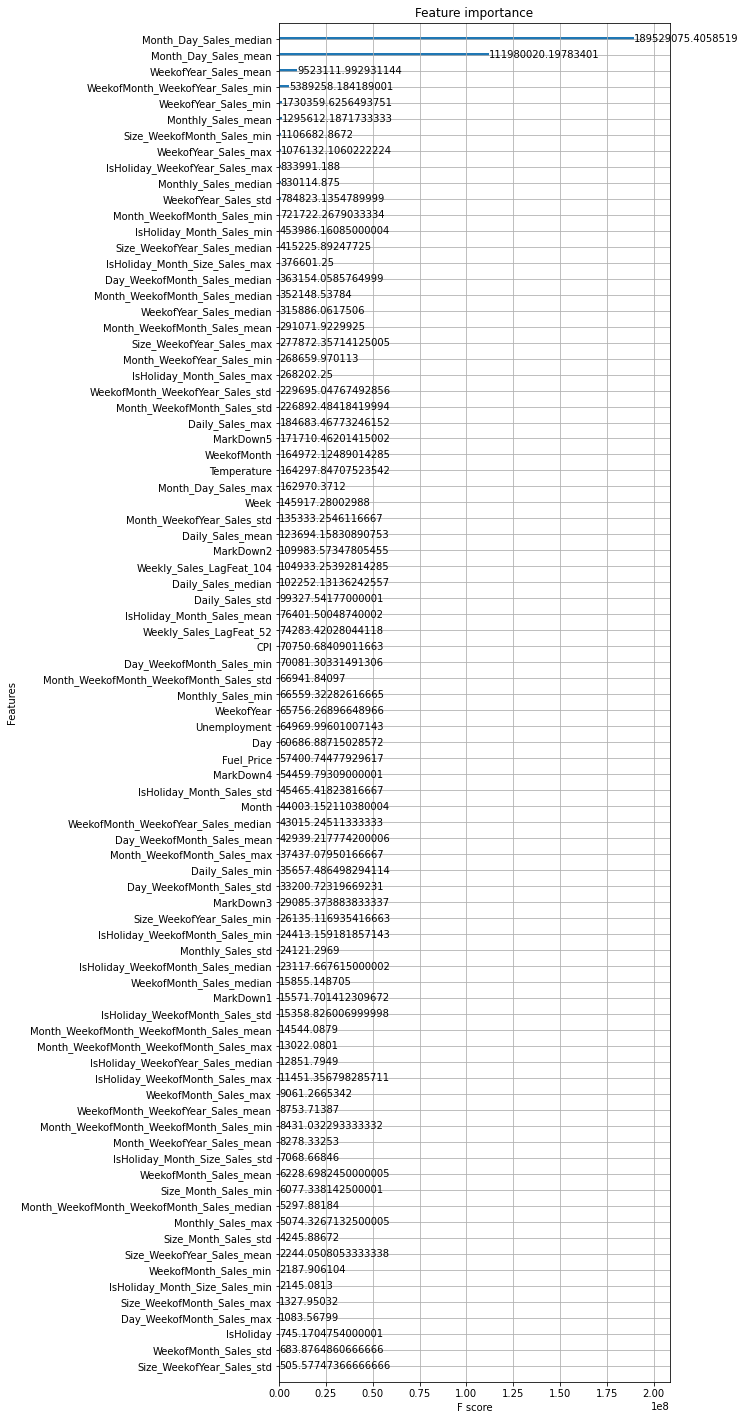

Store :  1  Dept : 2
Fitting 5 folds for each of 10 candidates, totalling 50 fits


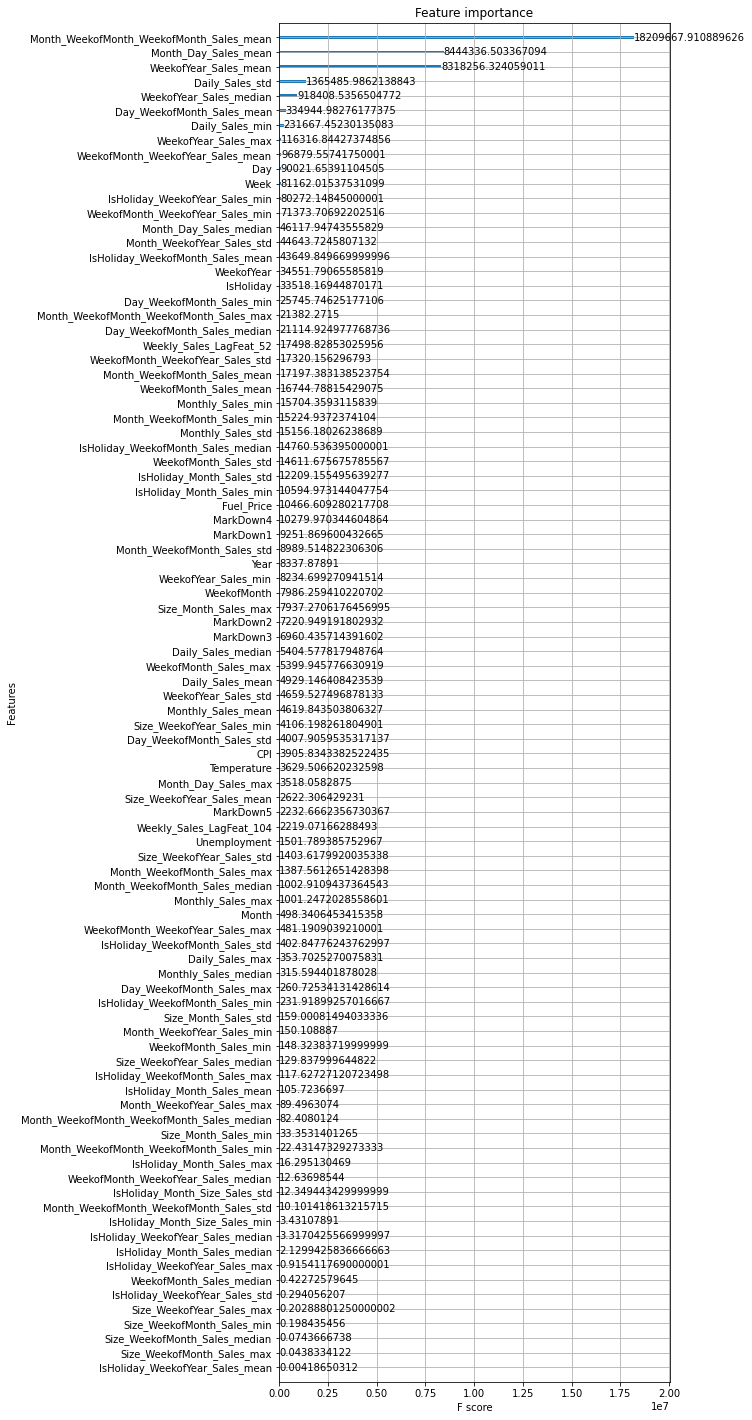

Store :  1  Dept : 3
Fitting 5 folds for each of 10 candidates, totalling 50 fits


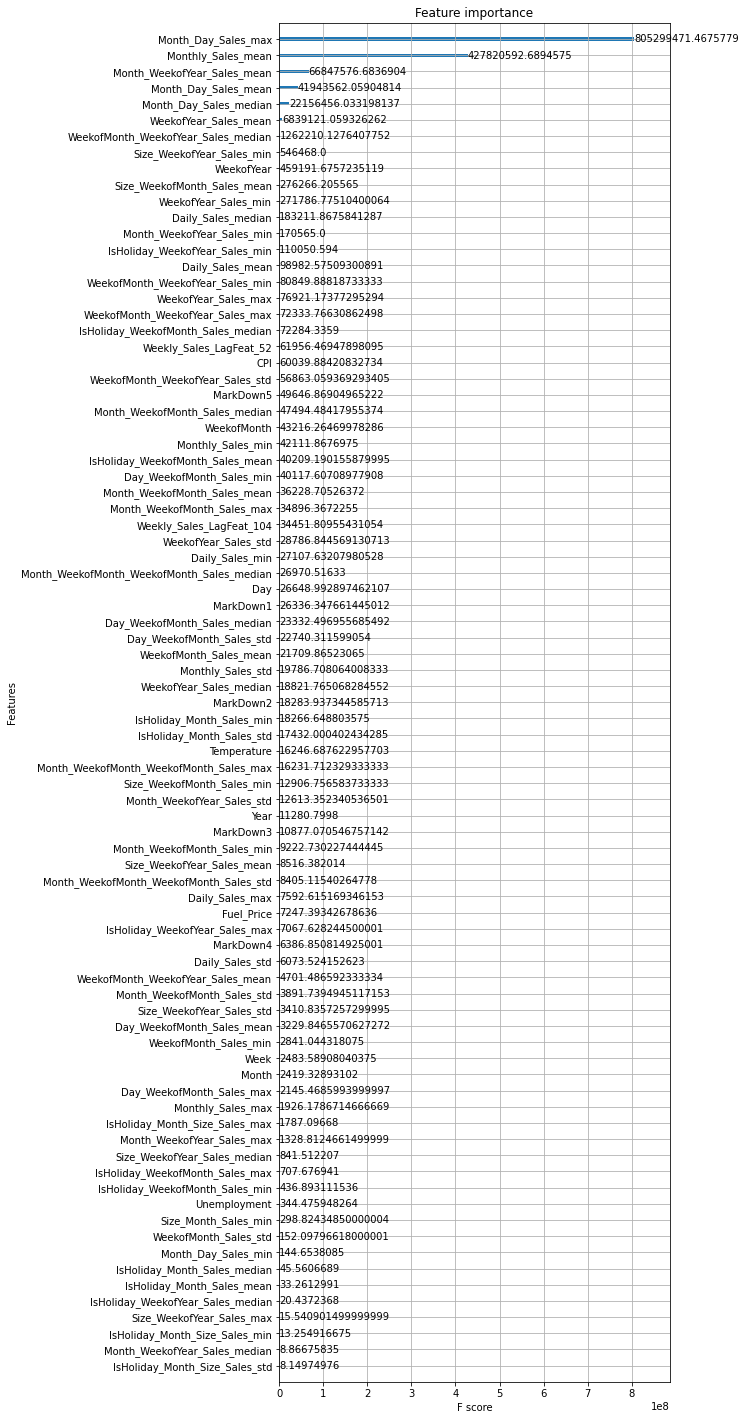

Store :  1  Dept : 4
Fitting 5 folds for each of 10 candidates, totalling 50 fits


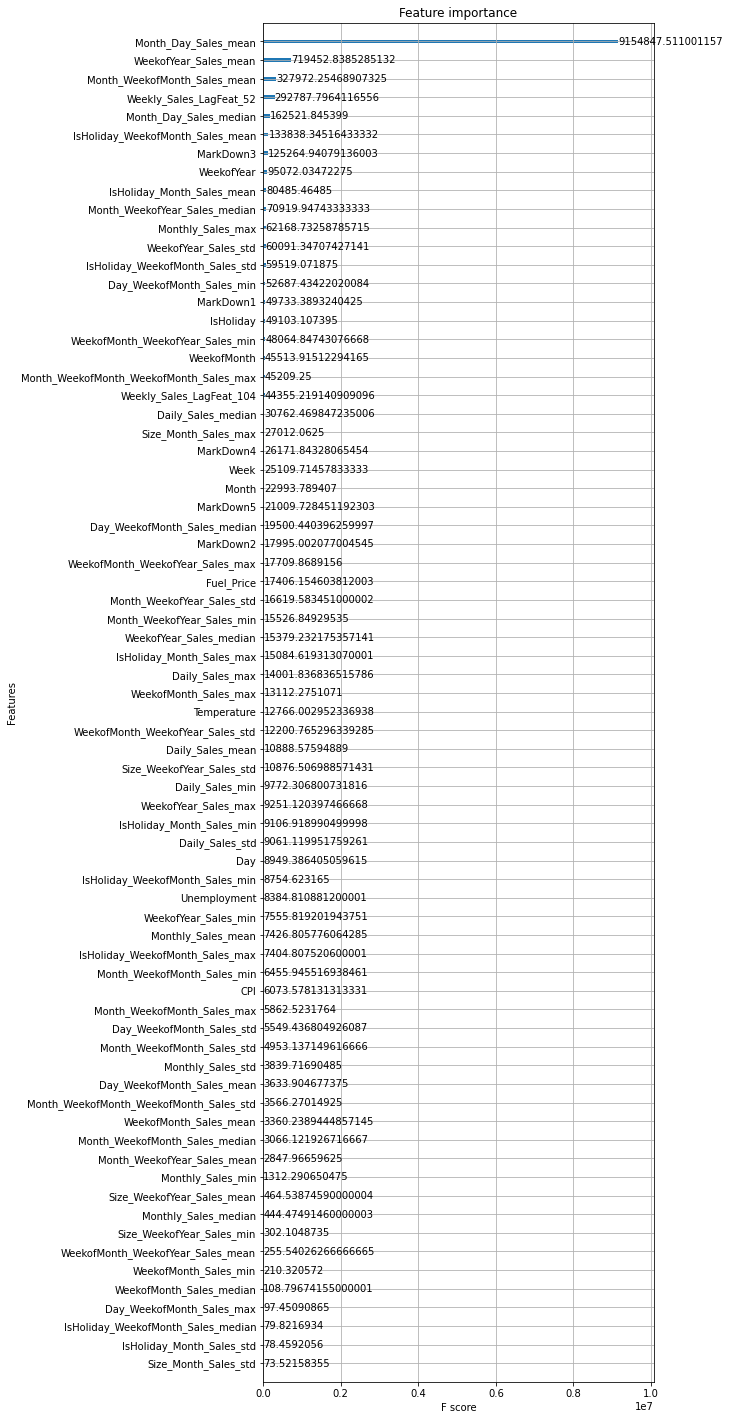

Store :  1  Dept : 5
Fitting 5 folds for each of 10 candidates, totalling 50 fits


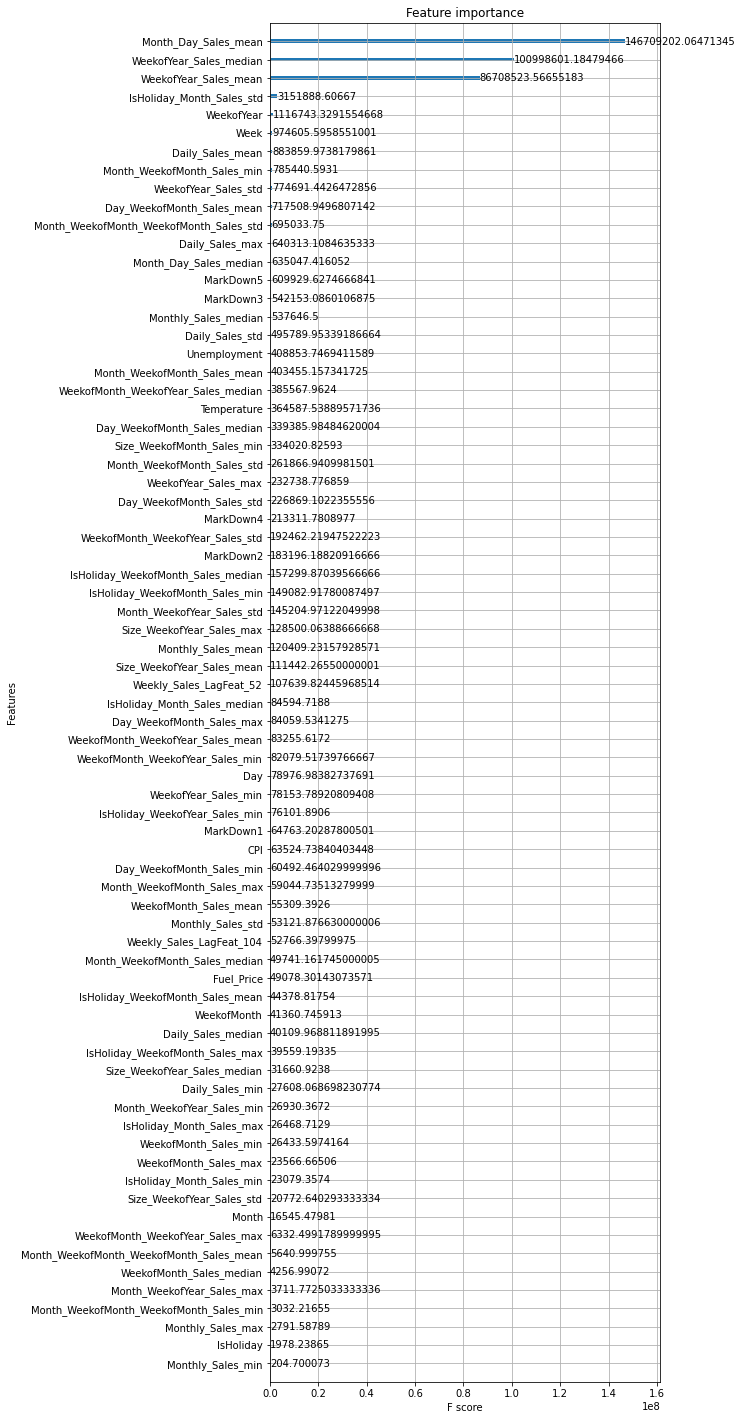

Store :  1  Dept : 6
Fitting 5 folds for each of 10 candidates, totalling 50 fits


KeyboardInterrupt: 

In [14]:
from sklearn.model_selection import RandomizedSearchCV
rgr = xgb.XGBRegressor(random_state=2021)

train = train.drop(['Date', 'train_or_test'], axis=1)
test = test.drop(['Date', 'train_or_test'], axis=1)

pred = []
store_dept_list = test[['Store','Dept']].drop_duplicates().values.tolist()

for tempStore, tempDept in store_dept_list:
    print ('Store : ', tempStore, ' Dept :', tempDept)
    x_train = train[(train['Store'] == tempStore) & (train['Dept'] == tempDept)].drop(['Weekly_Sales'], axis=1)
    y_train = train[(train['Store'] == tempStore) & (train['Dept'] == tempDept)]['Weekly_Sales']
    x_test = test[(test['Store'] == tempStore) & (test['Dept'] == tempDept)].drop(['Weekly_Sales'], axis=1)
 
    if len(x_train) >= 5:

        rgr = RandomizedSearchCV(estimator=rgr, param_distributions = xgb_params, scoring='neg_root_mean_squared_error', 
                                 n_jobs=2, n_iter = 10, cv=5, verbose=5)
        rgr = rgr.fit(x_train, y_train)
        rgr = rgr.best_estimator_.fit(x_train, y_train)
        predict_test = rgr.predict(x_test)
        
        fig, ax = plt.subplots(1, 1, figsize=(7, 25))
        xgb.plot_importance(rgr,
                            importance_type='gain',
                            show_values=True,
                           ax=ax)

        plt.show()

    elif len(x_train) >= 1:
        rgr = rgr.fit(x_train, y_train)
        predict_test = rgr.predict(x_test)
        
    else:
        predict_test = np.repeat(np.average(sales_train[sales_train['Dept'] == tempDept]['Weekly_Sales']), len(x_test))

    pred.extend(predict_test)

In [ ]:
ss = pd.read_csv('../data/raw_data/sampleSubmission.csv')
ss.loc[:, 'Weekly_Sales'] = pred
ss.to_csv('../files/submissions/XGB_rolling_52_104_0613_aggfeat_red.csv', index=False)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 25))
xgb.plot_importance(rgr,
                    importance_type='gain',
                    show_values=True,
                   ax=ax)

plt.show()

In [60]:
from sklearn.cluster import KMeans
import pandas as pd
 
num_cluster=10 # cluster数
 
clusters = KMeans(n_clusters = num_cluster, random_state = 0, n_jobs = -1)
clusters.fit(train.loc[:, train.columns[train.isnull().any() == False]])
centers = clusters.cluster_centers_

In [61]:
labels = clusters.labels_
labels

array([2, 6, 6, ..., 9, 9, 9], dtype=int32)

In [64]:
c, j = np.unique(labels, return_counts=True)

In [65]:
c

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [67]:
c, j = np.unique(labels, return_counts=True)
for i in range(0, len(j)):
    print(c[i], j[i])

0 53952
1 9021
2 51442
3 2482
4 19647
5 78335
6 38116
7 68571
8 5135
9 94869


In [73]:
c = list(train.columns[train.isnull().any() == False])
c.remove('Store')
train.loc[:, c]

,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Type_A,Type_B,...,Day_WeekofMonth_Sales_max,Day_WeekofMonth_Sales_min,WeekofMonth_WeekofYear_Sales_mean,WeekofMonth_WeekofYear_Sales_median,WeekofMonth_WeekofYear_Sales_max,WeekofMonth_WeekofYear_Sales_min,Month_WeekofMonth_WeekofMonth_Sales_mean,Month_WeekofMonth_WeekofMonth_Sales_median,Month_WeekofMonth_WeekofMonth_Sales_max,Month_WeekofMonth_WeekofMonth_Sales_min
0,1,24924.50,0,42.31,2.572,211.096358,8.106,151315,1,0,...,34238.88,15295.55,23366.916667,23510.49,24924.50,21665.76,23366.916667,23510.49,24924.50,21665.76
1,1,46039.49,1,38.51,2.548,211.242170,8.106,151315,1,0,...,46039.49,14539.79,40305.050000,37887.17,46039.49,36988.49,40305.050000,37887.17,46039.49,36988.49
2,1,41595.55,0,39.93,2.514,211.289143,8.106,151315,1,0,...,41595.55,14689.24,47500.506667,46845.87,54060.10,41595.55,47500.506667,46845.87,54060.10,41595.55
3,1,19403.54,0,46.63,2.561,211.319643,8.106,151315,1,0,...,27390.81,14537.37,19630.530000,19403.54,20124.22,19363.83,19630.530000,19403.54,20124.22,19363.83
4,1,21827.90,0,46.50,2.625,211.350143,8.106,151315,1,0,...,34238.88,15295.55,20756.180000,20327.61,21827.90,20113.03,20756.180000,20327.61,21827.90,20113.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536590,98,508.37,0,64.88,3.997,192.013558,8.684,118221,0,1,...,1167.90,97.28,617.710000,617.71,727.05,508.37,617.710000,617.71,727.05,508.37
536591,98,628.10,0,64.89,3.985,192.170412,8.667,118221,0,1,...,982.60,4.50,628.100000,628.10,628.10,628.10,628.100000,628.10,628.10,628.10
536592,98,1061.02,0,54.47,4.000,192.327265,8.667,118221,0,1,...,1061.02,18.50,1061.020000,1061.02,1061.02,1061.02,1061.020000,1061.02,1061.02,1061.02
536593,98,760.01,0,56.47,3.969,192.330854,8.667,118221,0,1,...,760.01,25.50,760.010000,760.01,760.01,760.01,760.010000,760.01,760.01,760.01
